In [1]:
import json
from search_clustering.pipeline import Pipeline
from search_clustering.client import *
from search_clustering.preprocessing import *
from search_clustering.embedding import *
from search_clustering.reduction import *
from search_clustering.clustering import *
from search_clustering.labeling import *


query = "energie"
samples = 100
use_cached_data = True

if not use_cached_data:
    es = ElasticClient()

    for index in es.client.indices.get_alias():
        print(index)

    results = es.search(index="faz", field="body", query=query, size=1_000)

    with open(f"results_{query}.json", "w") as json_file:
        json.dump(results, json_file)

else:
    with open(f"results_{query}.json", "r") as json_file:
        results = json.load(json_file)
        results = [
            res for res in results if res["_source"]["publication_date"] is not None
        ][:samples]


print(f"{len(results)} results")
# snippets = [res["snippet"] for res in results]
# bodies = [res["_source"]["body"] for res in results]
# titles = [res["_source"]["title"] for res in results]
# timestamps = [res["_source"]["publication_date"] for res in results]

100 results


[1/6] Preprocessing
[2/6] Embedding
[3/6] Reducing Dimensionality
[4/6] Clustering
[5/6] Labeling
[6/6] Visualizing


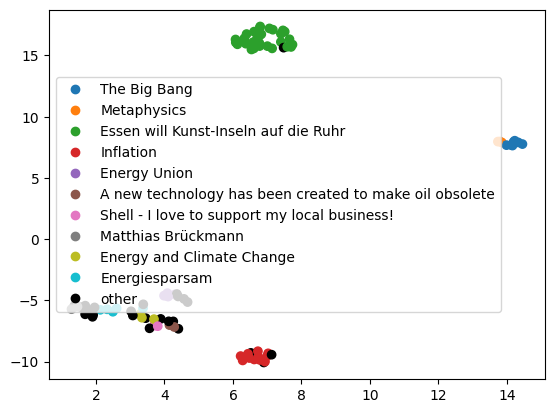

0.5686032

In [2]:
pipe = Pipeline(
    ParagraphKeywordPreprocessor(),
    SentenceMiniLM("topics"),
    DensMAP(),
    HDBSCAN(),
    Topically(),
)
vecs, clusters, labels, score = pipe.run(results, visualize=True)
score

In [3]:
for i in np.where(clusters == -1)[0]:
    print(results[i]["_source"]["title"])

Merkel lädt  Konzerne zum Energiegipfel
Gazprom bietet Europa mehr Gas an
Wenn es leuchtet, wird es kühler
TUI verkauft Preussag Energie
Donald Trump will „die Kohle retten“
Donald Trump will „die Kohle retten“
Eon warnt vor Zerfall des Energiemarkts
„Ich will diesen Unsinn nicht unterstützen“
„Es ist fast so weit“
Auch KTG Energie ist insolvent
Repräsentantenhaus billigt Bushs Energie-Pläne
China holt Amerika als größten Klimasünder ein
Unabhängig durch Erdwärme
Der kleinste Motor der Welt
KTG Energie will offenbar Insolvenzantrag prüfen
Die Dampfmaschine  für die Mikrowelt
Leben ohne Sonnenlicht
Gefährdet der Ukraine-Konflikt unsere Energieversorgung?
Deutschland muss Energieverbrauch stärker senken 
Gasexport als strategische Waffe gegen Russland
Ruckartige Katastrophe
Luftnummer mit Windrädern
Warum gutes Energiemanagement wichtig für die Leistung ist


In [4]:
from collections import Counter

Counter(clusters)

Counter({9: 6,
         2: 31,
         -1: 23,
         4: 5,
         7: 2,
         6: 3,
         3: 12,
         8: 3,
         10: 3,
         1: 3,
         5: 2,
         0: 7})

In [5]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

vectorizer_model = CountVectorizer(stop_words=stopwords.words("german"))
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model)

topics, probs = topic_model.fit_transform(titles, embeddings=vecs, y=clusters)

topic_model.topics_per_class(titles, clusters)
t_over_time = topic_model.topics_over_time(titles, timestamps, nr_bins=10)
topic_model.visualize_topics_over_time(t_over_time)

NameError: name 'titles' is not defined

In [ ]:
import pandas as pd
from datetime import datetime

algos = [KMeans(), HierarchicalClustering(), DBSCAN(), OPTICS()]

scores = {"algorithm": [], "silhouette": [], "time": []}

for algo in algos:
    start = datetime.now()
    pipe = Pipeline(DummyPreprocessor(), SentenceMiniLM(), algo, DummyLabeling())
    vecs, clusters, labels, score = pipe.run(results, visualize=False)
    end = datetime.now()

    scores["algorithm"].append(str(algo.__class__)[37:-2])
    scores["silhouette"].append(score)
    scores["time"].append(str(end - start))

pd.DataFrame(scores).sort_values(by="silhouette", ascending=False)

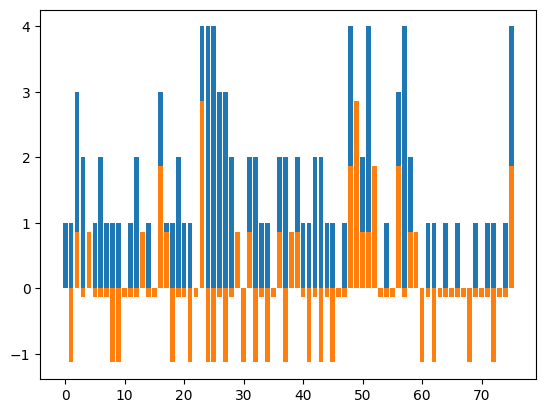

array([ 2,  4, 13, 16, 17, 23, 29, 31, 36, 38, 39, 48, 49, 50, 51, 52, 56,
       58, 59, 75])

In [332]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

timestamps = [res["_source"]["publication_date"][:10] for res in results]

df = pd.DataFrame(pd.to_datetime(timestamps), columns=["date"])

first_day = df.date.min()
last_day = df.date.max()
timespan = last_day - first_day
interval = timedelta(100)
bins = timespan // interval
real_interval = timespan / bins

hist = list(pd.np.histogram(df["date"].astype(int), bins=bins, density=False))
diff = abs(np.diff(hist[0]))

plt.bar(range(bins), hist[0])
plt.bar(np.arange(bins - 1) + 1, diff - np.mean(diff))
plt.show()

np.where(diff - np.mean(diff) > 0)[0] + 1

In [275]:
from datetime import timedelta

sign_changes = np.where(diff - np.mean(diff) > 0)

for i in range(1, bins):
    if np.sign(grad[i]) == 1:
        sign_changes.append(i)
sign_changes.append(
    bins
)  # set last boundary AFTER last bin so it's not an extra cluster

boundaries = [first_day + x * real_interval for x in sign_changes]
sign_changes

[0, 1, 5, 7, 16, 18, 19, 20]

In [163]:
def date_to_str(timestamp):
    return str(timestamp.date)[:10]


clusters = np.zeros(len(results), dtype=int)
label_parts = [first_day for _ in range(len(boundaries))]
labels = ["" for _ in range(len(boundaries) - 1)]

for i in range(len(boundaries) - 1):
    hits = df[df.date >= boundaries[i]][df.date < boundaries[i + 1]]
    clusters[hits.index] = i
    labels[i] = f"{date_to_str(hits.min())} - {date_to_str(hits.max())}"

labels

['2000-11-07 - 2002-10-09',
 '2002-12-27 - 2005-11-23',
 '2006-03-06 - 2006-10-10',
 '2007-04-18 - 2008-02-29',
 '2008-03-11 - 2008-10-29',
 '2009-06-04 - 2017-01-03',
 '2017-09-13 - 2018-03-01',
 '2018-09-28 - 2019-01-21',
 '2020-01-06 - 2021-10-13']

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from string import punctuation


def tokenize(doc: str) -> List[str]:
    tokens = word_tokenize(doc)
    tokens = [t for t in tokens if t not in stopwords.words("german")]
    return [t for t in tokens if t not in punctuation]


corpus_str = [tokenize(p) for p in paragraphs[0]]
id2word = Dictionary(corpus_str)
corpus_vec = [id2word.doc2bow(p) for p in corpus_str]

lda = LdaModel(corpus_vec, id2word=id2word)
topic_vecs = lda.get_document_topics(corpus_vec)